# US Immigration and Tourism Data Analytics

The main goal of this notebook is to validate the data model created by exploring the data to provide insights about the tourists and immigrants behaviours in US.


A few basic studies were created using PySpark and SQL queries.
1. [Most visited US cities](#q1)
2. [Top 10 Summer destinations](#q2)
3. [Top 10 Winter destinations](#q3)
4. [Most visited cities with breakdown per season](#q4)
5. [Most visited cities with breaking down per travel purposes](#q5)
6. [Where most visitors come from and how they arrive in US](#q6)
7. [Top Airlines that land in US by passengers count](#q7)
8. [Correlation between temperature and visitors](#q8)


Imports and Spark session building:

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0") \
    .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

Load all tables into dataframes:

In [ ]:
arrivals_df     = sqlContext.read.parquet('./data/trusted/arrivals/')
visa_df         = sqlContext.read.parquet('./data/trusted/visa/')
i94mode_df      = sqlContext.read.parquet('./data/trusted/i94mode/')
calendar_df     = sqlContext.read.parquet('./data/trusted/calendar/')
ports_df        = sqlContext.read.parquet('./data/trusted/ports/')
airlines_df     = sqlContext.read.parquet('./data/trusted/airlines/')
countries_df    = sqlContext.read.parquet('./data/trusted/countries/')
temperatures_df = sqlContext.read.parquet('./data/trusted/temperatures/')

Create views so we can create queries using SQL:

In [ ]:
arrivals_df.createOrReplaceTempView('arrivals')
visa_df.createOrReplaceTempView('visa')
i94mode_df.createOrReplaceTempView('i94mode')
calendar_df.createOrReplaceTempView('calendar')
ports_df.createOrReplaceTempView('ports')
airlines_df.createOrReplaceTempView('airlines')
countries_df.createOrReplaceTempView('countries')
temperatures_df.createOrReplaceTempView('temperatures')

---

<a id='q1'></a>
### Top 10 most visited US cities


In [ ]:
spark.sql('''

  SELECT p.city,
         p.state,
         count(a.id) visitors
    FROM arrivals a, 
         ports p       
   WHERE a.port = p.code
   GROUP BY p.city, p.state
   ORDER BY visitors desc
    
    ''').limit(10).toPandas()

---

<a id='q2'></a>
### Top 10 Summer destinations
*considering only the ones travelling with leisure purpose


In [ ]:
spark.sql('''

  SELECT p.city,
         p.state,
         count(a.id) visitors
    FROM arrivals a, 
         ports p,
         calendar c
   WHERE a.port = p.code
     AND c.date = a.arrival_date
     AND c.season_name = 'summer'
     AND a.visa = 2
   GROUP BY p.city, p.state
   ORDER BY visitors desc
    
    ''').limit(10).toPandas()

---

<a id='q3'></a>
### Top 10 Winter destinations  
*considering only the ones travelling with leisure purpose


In [ ]:
spark.sql('''

  SELECT p.city,
         p.state,
         count(a.id) visitors
    FROM arrivals a, 
         ports p,
         calendar c
   WHERE a.port = p.code
     AND c.date = a.arrival_date
     AND c.season_name = 'winter'
     AND a.visa = 2
   GROUP BY p.city, p.state
   ORDER BY visitors desc
    
    ''').limit(10).toPandas()

---

<a id='q4'></a>
### Most visited cities with breakdown per season:


In [ ]:
from pyspark.sql.functions import col, asc,desc
spark.sql('''

  SELECT p.city || ' - ' || p.state city,
         c.season_name season,
         count(a.id) visitors
    FROM arrivals a, 
         ports p,
         calendar c
   WHERE a.port = p.code
     AND c.date = a.arrival_date
   GROUP BY p.city, p.state, c.season_name
  HAVING visitors > 1000

UNION

  SELECT p.city || ' - ' || p.state city,
         'total' season,
         count(a.id) visitors
    FROM arrivals a, 
         ports p
   WHERE a.port = p.code
   GROUP BY p.city, p.state
  HAVING visitors > 1000


    ''').groupBy('city') \
        .pivot('season') \
        .sum('visitors') \
        .orderBy(col('total').desc(), col('city').asc()) \
        .select('city', 'spring', 'summer', 'fall', 'winter', 'total') \
        .limit(10).toPandas()


---

<a id='q5'></a>
### Most visited cities with breaking down per travel purposes


In [ ]:
from pyspark.sql.functions import col, asc,desc
spark.sql('''

  SELECT p.city || ' - ' || p.state city,
         v.purpose purpose,
         count(a.id) visitors
    FROM arrivals a, 
         ports p,
         visa v
   WHERE a.port = p.code
     AND a.visatype = v.type
   GROUP BY p.city, p.state, v.purpose
  HAVING visitors > 1000

UNION

  SELECT p.city || ' - ' || p.state city,
         'total' purpose,
         count(a.id) visitors
    FROM arrivals a, 
         ports p
   WHERE a.port = p.code
   GROUP BY p.city, p.state
  HAVING visitors > 1000


    ''').groupBy('city') \
        .pivot('purpose') \
        .sum('visitors') \
        .orderBy(col('total').desc(), col('city').asc()) \
        .limit(10).toPandas()

---

<a id='q6'></a>
### Where most visitors come from and how they arrive in US

In [ ]:
spark.sql('''

  SELECT c.country,
         i.description mode,
         count(a.id) visitors
    FROM arrivals a, 
         countries c,
         i94mode i
   WHERE a.country = c.code
     AND a.mode = i.code
   GROUP BY c.country, i.description

UNION

  SELECT c.country,
         'total' mode,
         count(a.id) visitors
    FROM arrivals a, 
         countries c
   WHERE a.country = c.code
   GROUP BY c.country
    
    ''').groupBy('country') \
        .pivot('mode') \
        .sum('visitors') \
        .orderBy(col('total').desc(), col('country').asc()) \
        .select('country', 'Air', 'Land', 'Sea', 'Not Reported', 'total') \
        .limit(20).toPandas()

---

<a id='q7'></a>
### Top Airlines that land in US by passengers count

In [103]:
spark.sql('''

  SELECT c.name airline,
         c.country airline_country,
         count(a.id) passengers
    FROM arrivals a, 
         airlines c
   WHERE a.airline = c.code
   GROUP BY c.name, c.country
   ORDER BY passengers DESC
   
    ''').limit(10).toPandas()

,airline,airline_country,passengers
0,American Airlines,United States,3765951
1,United Airlines,United States,3398487
2,Delta Air Lines,United States,2962904
3,British Airways,United Kingdom,2015160
4,Lufthansa Cargo,Germany,1291777
5,Lufthansa,Germany,1291777
6,Virgin Atlantic Airways,United Kingdom,1180003
7,Korean Air,Republic of Korea,891971
8,Japan Airlines,Japan,831542
9,Japan Airlines Domestic,Japan,831542


---

<a id='q8'></a>
### Trying to find a correlation between temperature and visitors  
* considering only a subset of cities


In [125]:
df = spark.sql('''

  SELECT p.city,
         t.month,
         c.month_name,
         round(t.avg_temp, 2) temperature,
         count(a.id) visitors
    FROM arrivals a,
         ports p,
         temperatures t,
         calendar c
   WHERE a.port = p.code
     AND UPPER(p.city) = UPPER(t.city)
     AND MONTH(a.arrival_date) = t.month
     AND a.arrival_date = c.date
     AND UPPER(p.city) IN ('NEW YORK', 'LOS ANGELES', 'MIAMI')
   GROUP BY p.city, t.month, t.avg_temp, c.month_name
   ORDER BY p.city, t.month
   
    ''').toPandas()

<AxesSubplot:xlabel='month'>

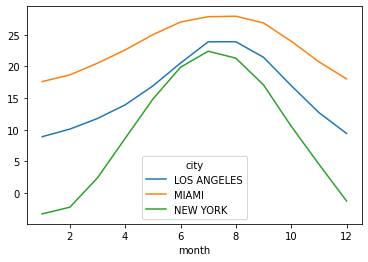

In [127]:
import matplotlib.pyplot as plt
df.pivot(index='month', columns='city', values='temperature').plot()

<AxesSubplot:xlabel='month'>

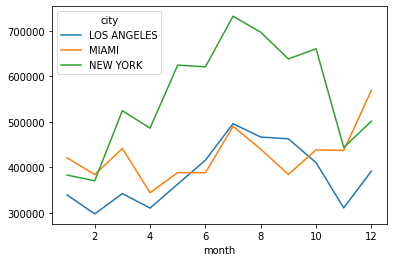

In [128]:
df.pivot(index='month', columns='city', values='visitors').plot()